In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import shap

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import FIVE_LAYERS
from events_package.input_getters import get_Y_1, get_X_5

In [2]:
Experiment.__version__

'5.0'

# 1. Importing Single Particle Data

## 1.1 Electrons

In [3]:
# importing data
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
)

electrons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
electrons.length

444840

In [4]:
electrons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998


## 1.2 Photons

In [5]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Photon\Parquet\1m_photon_pq"
)

photons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
photons.length

444142

In [6]:
photons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870


## 1.3 Neutral Pions

In [7]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiZero\Parquet\pq_pi0_2"
)

pi0 = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi0.length

412856

In [8]:
pi0.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483


## 1.4 Charged Pions

In [9]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiPlusMinus\Parquet\pq_piplusminus_2"
)

pi_char = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi_char.length

357554

In [10]:
pi_char.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 330809


## 1.5 Combining Different Particle Data

In [11]:
# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

In [12]:
experiment = electrons + photons + pi0 + pi_char

In [13]:
# all previous datasets have already been denoisified, duplicates were removed, no need to do it now
# in fact, doing it would delete some good events
experiment.shuffle_dataset(repeats=11)
print(experiment.length)

1592160


In [14]:
# split data into training and testing, next train XGBoost model
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)
print(experiment.X_test.shape)

params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "learning_rate": 0.18,
    # "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "n_estimators": 600,
}


experiment.train_xgboost_model(params)

(318433, 22)
INFO: Trained XGBoost model; mean squared error: 3655.5840579032492


3655.5840579032492

In [15]:
utils.count_nodes(experiment.model)

36658

In [16]:
mask_e = experiment.testing_dataset.physics_object_type == "electron"
mask_p = experiment.testing_dataset.physics_object_type == "photon"
mask_pi0 = experiment.testing_dataset.physics_object_type == "pi0"
mask_pi_char = experiment.testing_dataset.physics_object_type == "pi_char"

x_e1, y_e1, x_u_e1, u_e1 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=False,
)

x_p1, y_p1, x_u_p1, u_p1 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_p],
    y_values=(experiment.y_test - experiment.y_pred)[mask_p],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi01, y_pi01, x_u_pi01, u_pi01 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi0],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi0],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
    plot=False,
)

x_pi_char1, y_pi_char1, x_u_pi_char1, u_pi_char1 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi_char],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi_char],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
    plot=False,
)

In [17]:
len(x_pi_char1)

27

In [18]:
len(x_pi01)

32

# Hyperparameter Scan in Search of Smaller Model

In cells below, tables represent models trained with different hyperparameters: number of rounds (trees), max depth, colsumple by tree and learnign rate.

In the end, best model with < 2000 nodes was the one with 130 trees, max depth of 4, colsample of 1.0 and a surprisingly high learning rate of 0.74 (although there was no strong dependency on this parameter, compared to for example no trees or depth). this miniutarised model has 1950 nodes in total.

In [19]:
max_depth_range = [6]
learning_rate_range = [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
colsample_bytree_range = [0.6, 0.7, 0.8, 0.9, 1.0]
num_rounds_grid = [600]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range, learning_rate_range, colsample_bytree_range, num_rounds_grid
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams1 = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 3729.6181813896105
INFO: Trained XGBoost model; mean squared error: 3719.734628738978
INFO: Trained XGBoost model; mean squared error: 3726.5091619645073
INFO: Trained XGBoost model; mean squared error: 3727.3267151600967
INFO: Trained XGBoost model; mean squared error: 3738.711642347712
INFO: Trained XGBoost model; mean squared error: 3708.389621398466
INFO: Trained XGBoost model; mean squared error: 3705.540957032489
INFO: Trained XGBoost model; mean squared error: 3715.626210508703
INFO: Trained XGBoost model; mean squared error: 3716.187517908011
INFO: Trained XGBoost model; mean squared error: 3725.8120652640455
INFO: Trained XGBoost model; mean squared error: 3702.4049721559154
INFO: Trained XGBoost model; mean squared error: 3685.898959259418
INFO: Trained XGBoost model; mean squared error: 3696.663347474905
INFO: Trained XGBoost model; mean squared error: 3700.3776159126
INFO: Trained XGBoost model; mean squared error: 3706.09172

In [20]:
experiment_hyperparams1.sort_values(by="MSE")

,MSE,objective,max_depth,learning_rate,colsample_bytree,n_estimators,Nodes NO
41,3637.841891,reg:squarederror,6,0.18,0.7,600,36515
51,3639.066005,reg:squarederror,6,0.20,0.7,600,36661
46,3640.112490,reg:squarederror,6,0.19,0.7,600,36526
53,3641.476783,reg:squarederror,6,0.20,0.9,600,36296
48,3645.367318,reg:squarederror,6,0.19,0.9,600,36435
47,3645.644535,reg:squarederror,6,0.19,0.8,600,36407
43,3646.213447,reg:squarederror,6,0.18,0.9,600,36406
49,3647.337891,reg:squarederror,6,0.19,1.0,600,36316
45,3650.933284,reg:squarederror,6,0.19,0.6,600,36767
40,3651.679063,reg:squarederror,6,0.18,0.6,600,36678


In [21]:
max_depth_range = [3, 4, 5, 6]
learning_rate_range = [0.18]
colsample_bytree_range = [0.8]
num_rounds_grid = [130, 150, 200, 300, 400, 500, 600]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range, learning_rate_range, colsample_bytree_range, num_rounds_grid
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams2 = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 5575.698593220305
INFO: Trained XGBoost model; mean squared error: 5422.546480908264
INFO: Trained XGBoost model; mean squared error: 5132.588527618396
INFO: Trained XGBoost model; mean squared error: 4808.214643733089
INFO: Trained XGBoost model; mean squared error: 4633.63521372839
INFO: Trained XGBoost model; mean squared error: 4522.568793536056
INFO: Trained XGBoost model; mean squared error: 4433.014283563007
INFO: Trained XGBoost model; mean squared error: 4791.215980031763
INFO: Trained XGBoost model; mean squared error: 4684.241609397406
INFO: Trained XGBoost model; mean squared error: 4483.280323246675
INFO: Trained XGBoost model; mean squared error: 4259.735191006611
INFO: Trained XGBoost model; mean squared error: 4123.772383507637
INFO: Trained XGBoost model; mean squared error: 4037.098641611588
INFO: Trained XGBoost model; mean squared error: 3974.6302869790243
INFO: Trained XGBoost model; mean squared error: 4343.22422272

In [22]:
experiment_hyperparams2.sort_values(by="MSE")

,MSE,objective,max_depth,learning_rate,colsample_bytree,n_estimators,Nodes NO
27,3655.584058,reg:squarederror,6,0.18,0.8,600,36658
26,3684.226752,reg:squarederror,6,0.18,0.8,500,30615
25,3728.404627,reg:squarederror,6,0.18,0.8,400,24558
20,3762.000028,reg:squarederror,5,0.18,0.8,600,18406
24,3802.405014,reg:squarederror,6,0.18,0.8,300,18524
19,3803.170989,reg:squarederror,5,0.18,0.8,500,15370
18,3873.461805,reg:squarederror,5,0.18,0.8,400,12307
23,3927.236374,reg:squarederror,6,0.18,0.8,200,12429
17,3966.592329,reg:squarederror,5,0.18,0.8,300,9262
13,3974.630287,reg:squarederror,4,0.18,0.8,600,8984


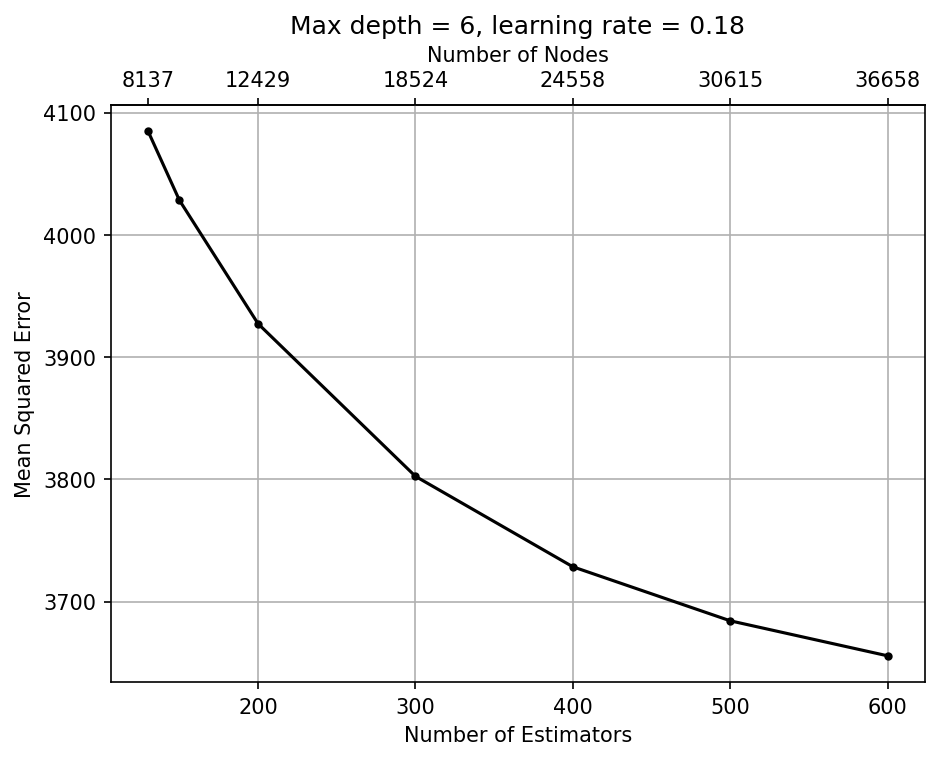

In [23]:
mask2 = np.where(experiment_hyperparams2["max_depth"] == 6)

fig, ax1 = plt.subplots(figsize=(7, 5), dpi=150)

# Plot MSE vs Num_rounds
ax1.plot(
    experiment_hyperparams2.loc[mask2]["n_estimators"],
    experiment_hyperparams2.loc[mask2]["MSE"],
    ".-",
    color="k",
)
ax1.set_xlabel("Number of Estimators")
ax1.set_ylabel("Mean Squared Error")
ax1.tick_params(axis="y")

# Create a secondary x-axis on top
ax2 = ax1.secondary_xaxis("top")

# Set the tick positions and labels for Nodes NO
ax2.set_xticks(
    experiment_hyperparams2.loc[mask2]["n_estimators"].values[[0, 2, 3, 4, 5, 6]]
)
ax2.set_xticklabels(
    experiment_hyperparams2.loc[mask2]["Nodes NO"].values[[0, 2, 3, 4, 5, 6]]
)
ax2.set_xlabel("Number of Nodes", color="k")

# Set the x-axis tick label color to blue
ax2.tick_params(axis="x", colors="k")

# Set title
plt.title("Max depth = 6, learning rate = 0.18")

# Show grid
ax1.grid(True)

plt.show()

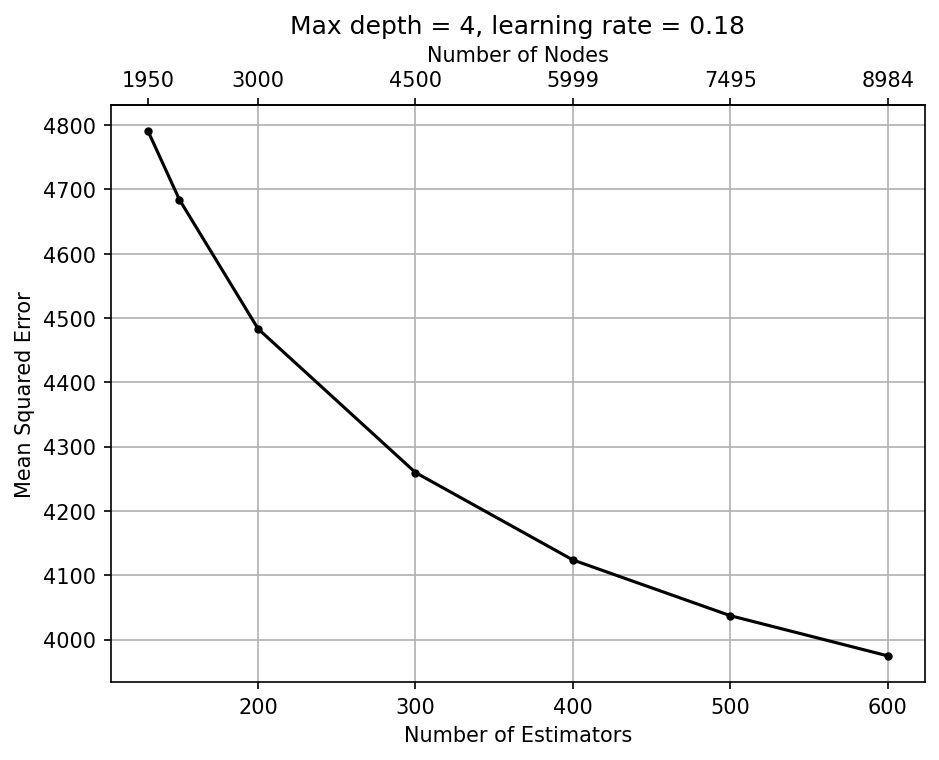

In [24]:
mask2 = np.where(experiment_hyperparams2["max_depth"] == 4)

fig, ax1 = plt.subplots(figsize=(7, 5), dpi=150)

# Plot MSE vs Num_rounds
ax1.plot(
    experiment_hyperparams2.loc[mask2]["n_estimators"],
    experiment_hyperparams2.loc[mask2]["MSE"],
    ".-",
    color="k",
)
ax1.set_xlabel("Number of Estimators")
ax1.set_ylabel("Mean Squared Error")
ax1.tick_params(axis="y")

# Create a secondary x-axis on top
ax2 = ax1.secondary_xaxis("top")

# Set the tick positions and labels for Nodes NO
ax2.set_xticks(
    experiment_hyperparams2.loc[mask2]["n_estimators"].values[[0, 2, 3, 4, 5, 6]]
)
ax2.set_xticklabels(
    experiment_hyperparams2.loc[mask2]["Nodes NO"].values[[0, 2, 3, 4, 5, 6]]
)
ax2.set_xlabel("Number of Nodes", color="k")

# Set the x-axis tick label color to blue
ax2.tick_params(axis="x", colors="k")

# Set title
plt.title("Max depth = 4, learning rate = 0.18")

# Show grid
ax1.grid(True)

plt.show()

In [25]:
max_depth_range = [4]
learning_rate_range = [
    0.1,
    0.11,
    0.12,
    0.13,
    0.14,
    0.15,
    0.16,
    0.17,
    0.18,
    0.19,
    0.2,
    0.21,
    0.22,
    0.23,
    0.24,
    0.25,
    0.26,
    0.27,
    0.28,
    0.29,
    0.30,
    0.31,
    0.32,
    0.33,
    0.34,
    0.35,
    0.36,
    0.37,
    0.38,
    0.39,
    0.40,
    0.41,
    0.42,
    0.43,
    0.44,
    0.45,
    0.46,
    0.48,
    0.5,
    0.52,
    0.53,
    0.55,
    0.57,
    0.59,
    0.6,
    0.63,
    0.65,
    0.66,
    0.67,
    0.68,
    0.69,
    0.7,
    0.71,
    0.72,
    0.73,
    0.74,
    0.75,
    0.76,
    0.77,
    0.78,
    0.79,
    0.8,
    0.81,
    0.82,
    0.83,
    0.84,
    0.85,
]
colsample_bytree_range = [0.6, 0.7, 0.8, 0.9, 1.0]
num_rounds_grid = [130]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range, learning_rate_range, colsample_bytree_range, num_rounds_grid
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams3 = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 5493.516093852475
INFO: Trained XGBoost model; mean squared error: 5391.391228772838
INFO: Trained XGBoost model; mean squared error: 5356.238401584371
INFO: Trained XGBoost model; mean squared error: 5359.3184265021
INFO: Trained XGBoost model; mean squared error: 5343.838029577202
INFO: Trained XGBoost model; mean squared error: 5386.315224665255
INFO: Trained XGBoost model; mean squared error: 5251.097833242782
INFO: Trained XGBoost model; mean squared error: 5230.342283068851
INFO: Trained XGBoost model; mean squared error: 5236.528201788255
INFO: Trained XGBoost model; mean squared error: 5225.872698799752
INFO: Trained XGBoost model; mean squared error: 5305.780223428674
INFO: Trained XGBoost model; mean squared error: 5193.5665984606185
INFO: Trained XGBoost model; mean squared error: 5161.209607324773
INFO: Trained XGBoost model; mean squared error: 5172.346654847743
INFO: Trained XGBoost model; mean squared error: 5136.034003884

In [26]:
experiment_hyperparams3.sort_values(by="MSE")

,MSE,objective,max_depth,learning_rate,colsample_bytree,n_estimators,Nodes NO
267,4321.000130,reg:squarederror,4,0.72,0.8,130,1950
289,4326.330714,reg:squarederror,4,0.76,1.0,130,1950
248,4327.283201,reg:squarederror,4,0.68,0.9,130,1950
249,4331.326025,reg:squarederror,4,0.68,1.0,130,1950
263,4332.728919,reg:squarederror,4,0.71,0.9,130,1949
...,...,...,...,...,...,...,...
2,5356.238402,reg:squarederror,4,0.10,0.8,130,1950
3,5359.318427,reg:squarederror,4,0.10,0.9,130,1950
5,5386.315225,reg:squarederror,4,0.11,0.6,130,1950
1,5391.391229,reg:squarederror,4,0.10,0.7,130,1950


Text(0.5, 1.0, 'Nodes: 1950, Rounds: 130, Depth: 4, colsample_bytree: 1.0')

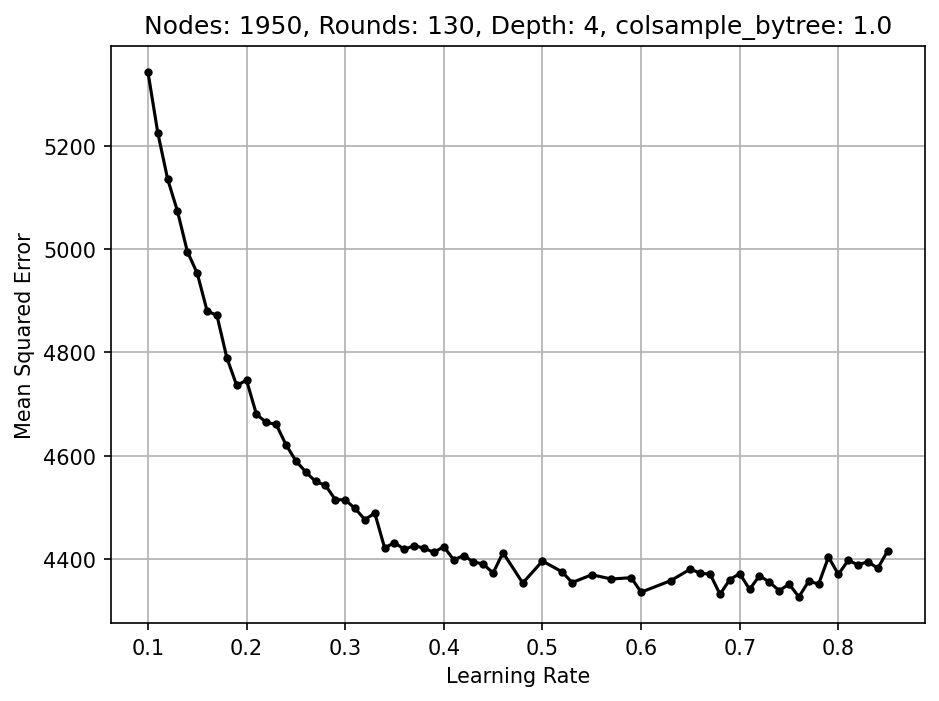

In [27]:
mask4 = np.where(experiment_hyperparams3["colsample_bytree"] == 1.0)

plt.figure(figsize=(7, 5), dpi=150)
plt.plot(
    experiment_hyperparams3.loc[mask4]["learning_rate"],
    experiment_hyperparams3.loc[mask4]["MSE"],
    ".-",
    color="k",
)
plt.grid()
plt.ylabel("Mean Squared Error")
plt.xlabel("Learning Rate")
plt.title("Nodes: 1950, Rounds: 130, Depth: 4, colsample_bytree: 1.0")

In [28]:
max_depth_range = [4, 5]
learning_rate_range = [0.74]
colsample_bytree_range = [1.0]
num_rounds_grid = [60, 65, 70, 75, 80, 85, 100, 130]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range, learning_rate_range, colsample_bytree_range, num_rounds_grid
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams4 = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 4836.675331057858
INFO: Trained XGBoost model; mean squared error: 4777.8693737385365
INFO: Trained XGBoost model; mean squared error: 4709.915055953709
INFO: Trained XGBoost model; mean squared error: 4679.562724904651
INFO: Trained XGBoost model; mean squared error: 4648.743188156498
INFO: Trained XGBoost model; mean squared error: 4624.317121715827
INFO: Trained XGBoost model; mean squared error: 4485.117506021326
INFO: Trained XGBoost model; mean squared error: 4338.286588674741
INFO: Trained XGBoost model; mean squared error: 4546.477659085966
INFO: Trained XGBoost model; mean squared error: 4498.886400307412
INFO: Trained XGBoost model; mean squared error: 4465.516348606335
INFO: Trained XGBoost model; mean squared error: 4428.87755818208
INFO: Trained XGBoost model; mean squared error: 4407.5426157231495
INFO: Trained XGBoost model; mean squared error: 4388.08104525943
INFO: Trained XGBoost model; mean squared error: 4287.64540078

In [29]:
experiment_hyperparams4.sort_values(by="MSE")

,MSE,objective,max_depth,learning_rate,colsample_bytree,n_estimators,Nodes NO
15,4196.380197,reg:squarederror,5,0.74,1.0,130,4000
14,4287.645401,reg:squarederror,5,0.74,1.0,100,3090
7,4338.286589,reg:squarederror,4,0.74,1.0,130,1949
13,4388.081045,reg:squarederror,5,0.74,1.0,85,2625
12,4407.542616,reg:squarederror,5,0.74,1.0,80,2472
11,4428.877558,reg:squarederror,5,0.74,1.0,75,2318
10,4465.516349,reg:squarederror,5,0.74,1.0,70,2163
6,4485.117506,reg:squarederror,4,0.74,1.0,100,1500
9,4498.886400,reg:squarederror,5,0.74,1.0,65,2011
8,4546.477659,reg:squarederror,5,0.74,1.0,60,1857


In [30]:
max_depth_range = [3, 4, 5, 6]
learning_rate_range = [0.74]
colsample_bytree_range = [1.0]
num_rounds_grid = [130, 150, 200, 275, 300, 600]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range, learning_rate_range, colsample_bytree_range, num_rounds_grid
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams5 = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True
)

INFO: Trained XGBoost model; mean squared error: 4715.02064931426
INFO: Trained XGBoost model; mean squared error: 4634.458665151751
INFO: Trained XGBoost model; mean squared error: 4470.716845056712
INFO: Trained XGBoost model; mean squared error: 4319.092897106395
INFO: Trained XGBoost model; mean squared error: 4277.020865625699
INFO: Trained XGBoost model; mean squared error: 4019.833855342227
INFO: Trained XGBoost model; mean squared error: 4338.286588674741
INFO: Trained XGBoost model; mean squared error: 4280.4370557706125
INFO: Trained XGBoost model; mean squared error: 4161.168947820898
INFO: Trained XGBoost model; mean squared error: 4045.4704507237793
INFO: Trained XGBoost model; mean squared error: 4015.864298361913
INFO: Trained XGBoost model; mean squared error: 3882.0860378225307
INFO: Trained XGBoost model; mean squared error: 4196.380196923963
INFO: Trained XGBoost model; mean squared error: 4147.255036750878
INFO: Trained XGBoost model; mean squared error: 4057.154594

In [31]:
experiment_hyperparams5.sort_values(by="MSE")

,MSE,objective,max_depth,learning_rate,colsample_bytree,n_estimators,Nodes NO
11,3882.086038,reg:squarederror,4,0.74,1.0,600,8983
17,3972.351264,reg:squarederror,5,0.74,1.0,600,18348
16,3984.195210,reg:squarederror,5,0.74,1.0,300,9198
15,4000.685172,reg:squarederror,5,0.74,1.0,275,8428
10,4015.864298,reg:squarederror,4,0.74,1.0,300,4496
5,4019.833855,reg:squarederror,3,0.74,1.0,600,4199
9,4045.470451,reg:squarederror,4,0.74,1.0,275,4122
14,4057.154595,reg:squarederror,5,0.74,1.0,200,6137
20,4074.741393,reg:squarederror,6,0.74,1.0,200,12264
21,4075.041793,reg:squarederror,6,0.74,1.0,275,16810


In [32]:
# train miniaturised model
print(experiment.X_test.shape)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "learning_rate": 0.74,
    # "gamma": 6,  # min split loss
    "colsample_bytree": 1.0,
    "eval_metric": "rmse",
    "n_estimators": 130,
}


experiment.train_xgboost_model(params)  # 4338

(318433, 22)


INFO: Trained XGBoost model; mean squared error: 4338.286588674741


4338.286588674741

In [33]:
utils.count_nodes(experiment.model)

1949

In [34]:
mask_e = experiment.testing_dataset.physics_object_type == "electron"
mask_p = experiment.testing_dataset.physics_object_type == "photon"
mask_pi0 = experiment.testing_dataset.physics_object_type == "pi0"
mask_pi_char = experiment.testing_dataset.physics_object_type == "pi_char"

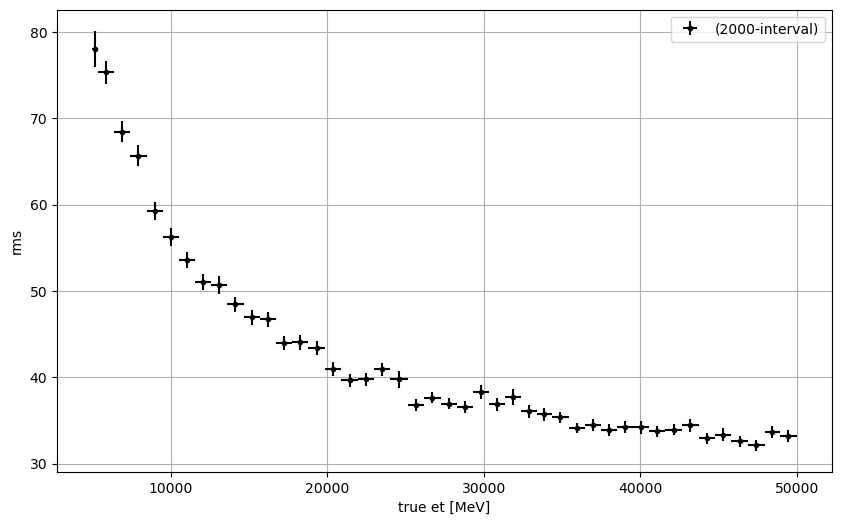

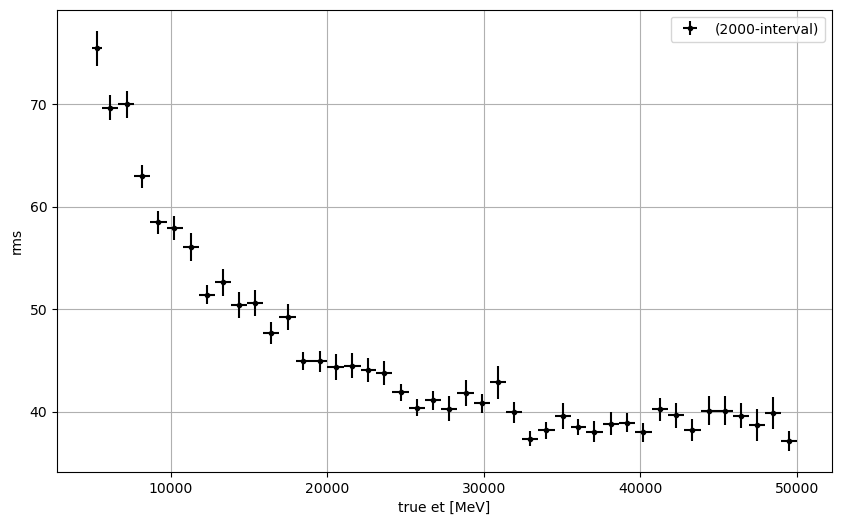

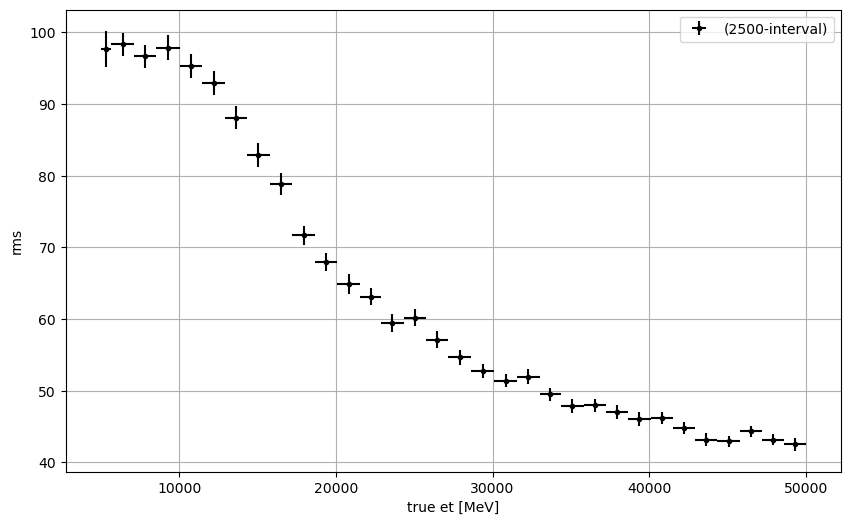

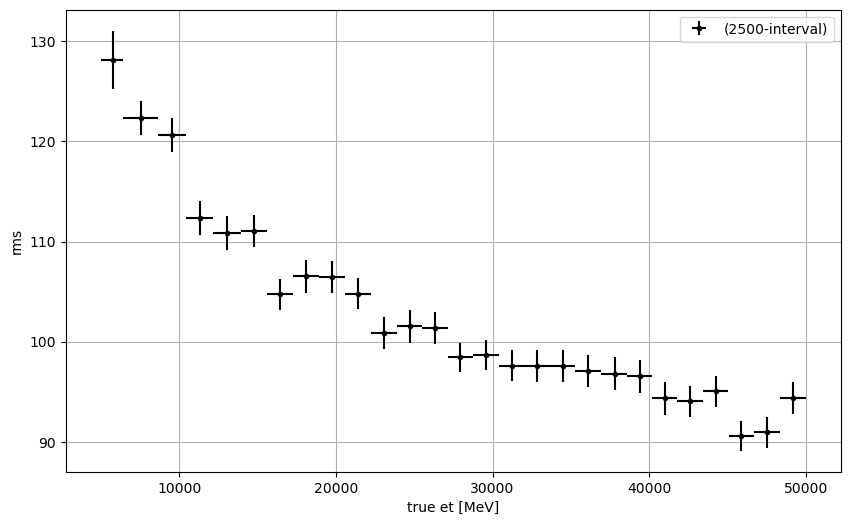

In [35]:
x_e, y_e, x_u_e, u_e = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
)

x_p, y_p, x_u_p, u_p = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_p],
    y_values=(experiment.y_test - experiment.y_pred)[mask_p],
    interval=2000,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
)

x_pi0, y_pi0, x_u_pi0, u_pi0 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi0],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi0],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
)

x_pi_char, y_pi_char, x_u_pi_char, u_pi_char = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi_char],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi_char],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
)

In [36]:
len(y_p)

44

In [37]:
len(y_p1)

44

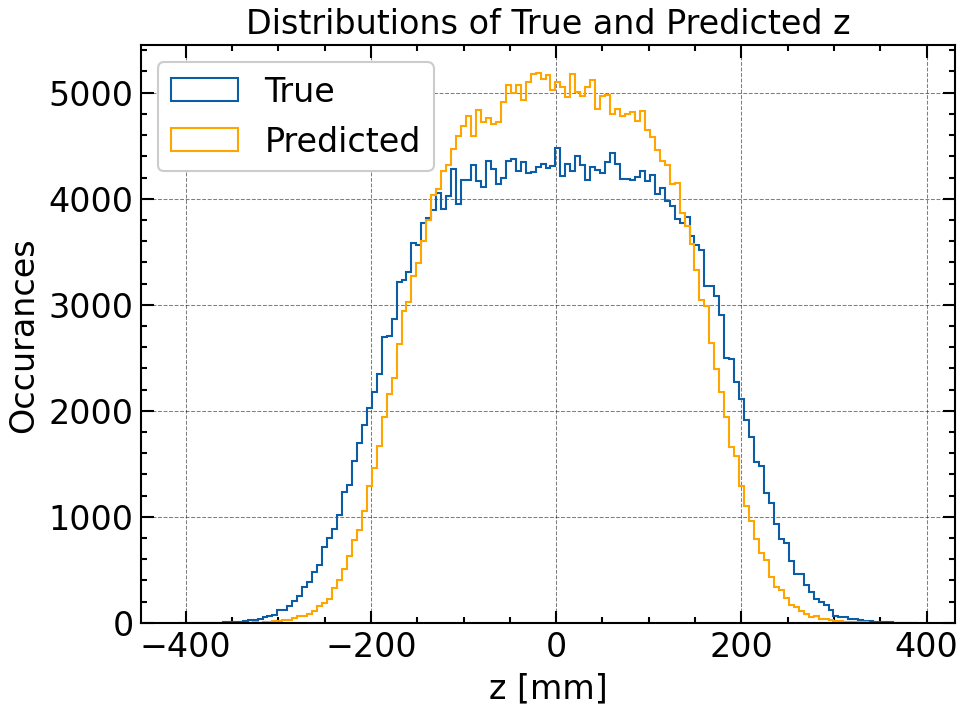

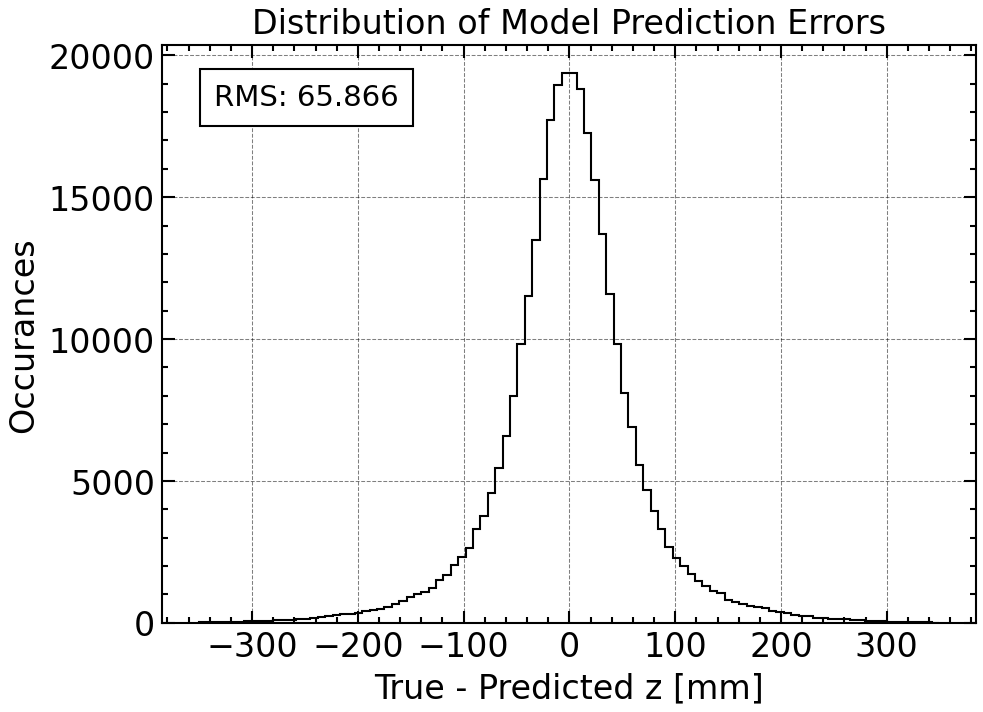

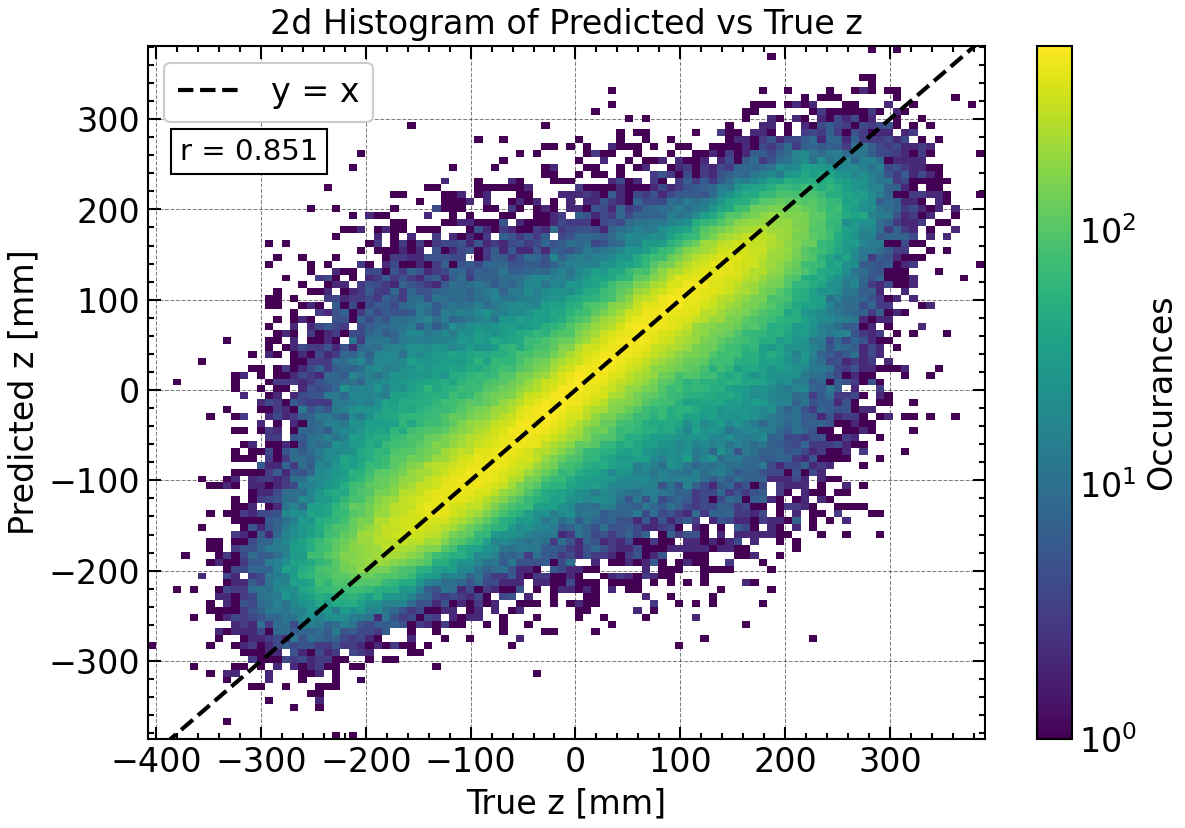

In [38]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

# Comparison

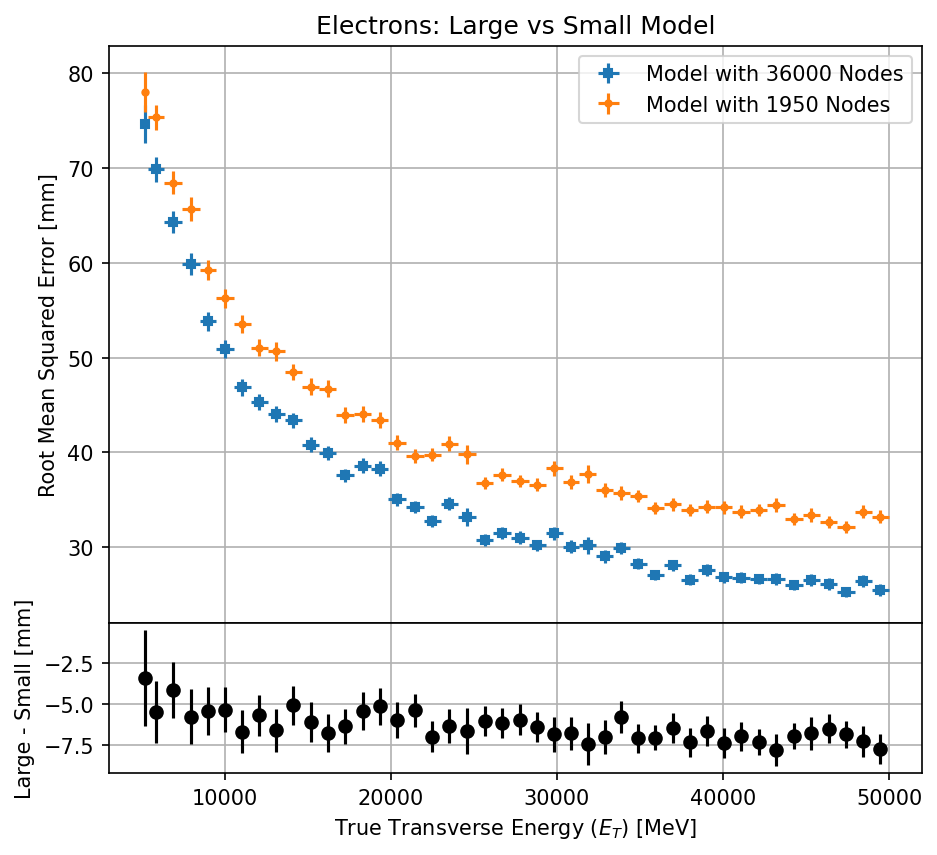

In [39]:
plt.figure(figsize=(7, 5), dpi=150)

# First plot
plt.errorbar(
    x_e1,
    y_e1,
    xerr=x_u_e1,
    yerr=u_e1,
    fmt="s",
    markersize=4,
    label="Model with 36000 Nodes",
)

# Second plot
plt.errorbar(
    x_e,
    y_e,
    xerr=x_u_e,
    yerr=u_e,
    fmt=".",
    label="Model with 1950 Nodes",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Electrons: Large vs Small Model")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_e1) - np.array(y_e)

# Plot the differences
plt.errorbar(
    x_e,
    differences,
    yerr=np.sqrt(u_e**2 + u_e1**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Large - Small [mm]")

plt.grid()
plt.show()

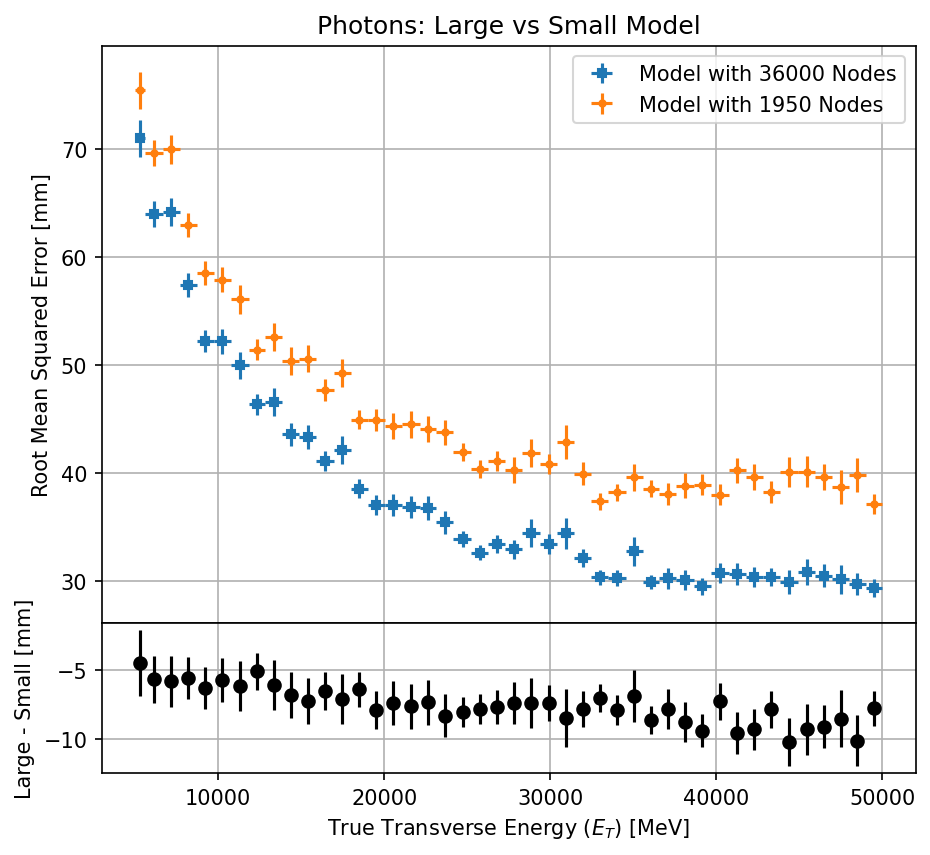

In [40]:
plt.figure(figsize=(7, 5), dpi=150)

# First plot
plt.errorbar(
    x_p1,
    y_p1,
    xerr=x_u_p1,
    yerr=u_p1,
    fmt="s",
    markersize=4,
    label="Model with 36000 Nodes",
)

# Second plot
plt.errorbar(
    x_p,
    y_p,
    xerr=x_u_p,
    yerr=u_p,
    fmt=".",
    label="Model with 1950 Nodes",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Photons: Large vs Small Model")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_p1) - np.array(y_p)

# Plot the differences
plt.errorbar(
    x_p,
    differences,
    yerr=np.sqrt(u_p**2 + u_p1**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Large - Small [mm]")

plt.grid()
plt.show()

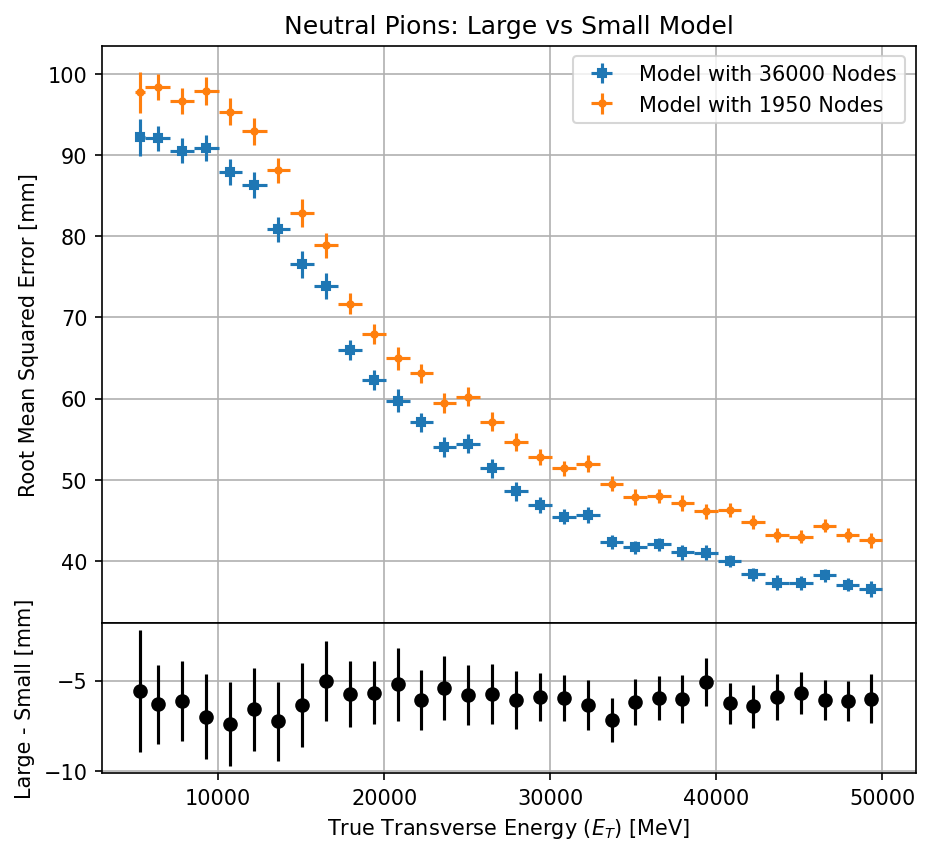

In [41]:
plt.figure(figsize=(7, 5), dpi=150)

# First plot
plt.errorbar(
    x_pi01,
    y_pi01,
    xerr=x_u_pi01,
    yerr=u_pi01,
    fmt="s",
    markersize=4,
    label="Model with 36000 Nodes",
)

# Second plot
plt.errorbar(
    x_pi0,
    y_pi0,
    xerr=x_u_pi0,
    yerr=u_pi0,
    fmt=".",
    label="Model with 1950 Nodes",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Neutral Pions: Large vs Small Model")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_pi01) - np.array(y_pi0)

# Plot the differences
plt.errorbar(
    x_pi0,
    differences,
    yerr=np.sqrt(u_pi0**2 + u_pi01**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Large - Small [mm]")

plt.grid()
plt.show()

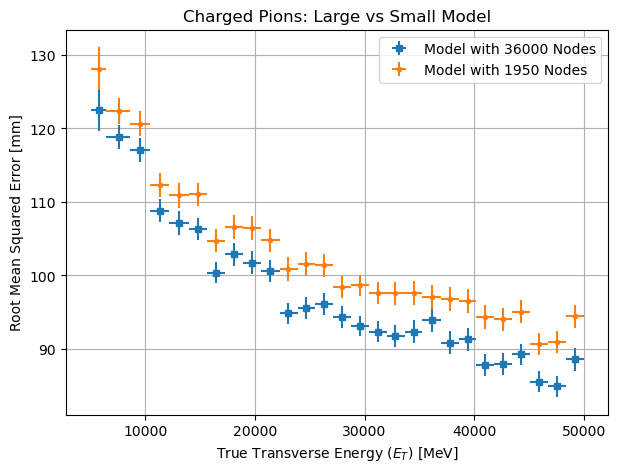

In [42]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    x_pi_char1,
    y_pi_char1,
    xerr=x_u_pi_char1,
    yerr=u_pi_char1,
    fmt="s",
    markersize=4,
    label="Model with 36000 Nodes",
)
plt.errorbar(
    x_pi_char,
    y_pi_char,
    xerr=x_u_pi_char,
    yerr=u_pi_char,
    fmt=".",
    label="Model with 1950 Nodes",
)


# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Charged Pions: Large vs Small Model")

plt.legend()
plt.grid()
plt.show()

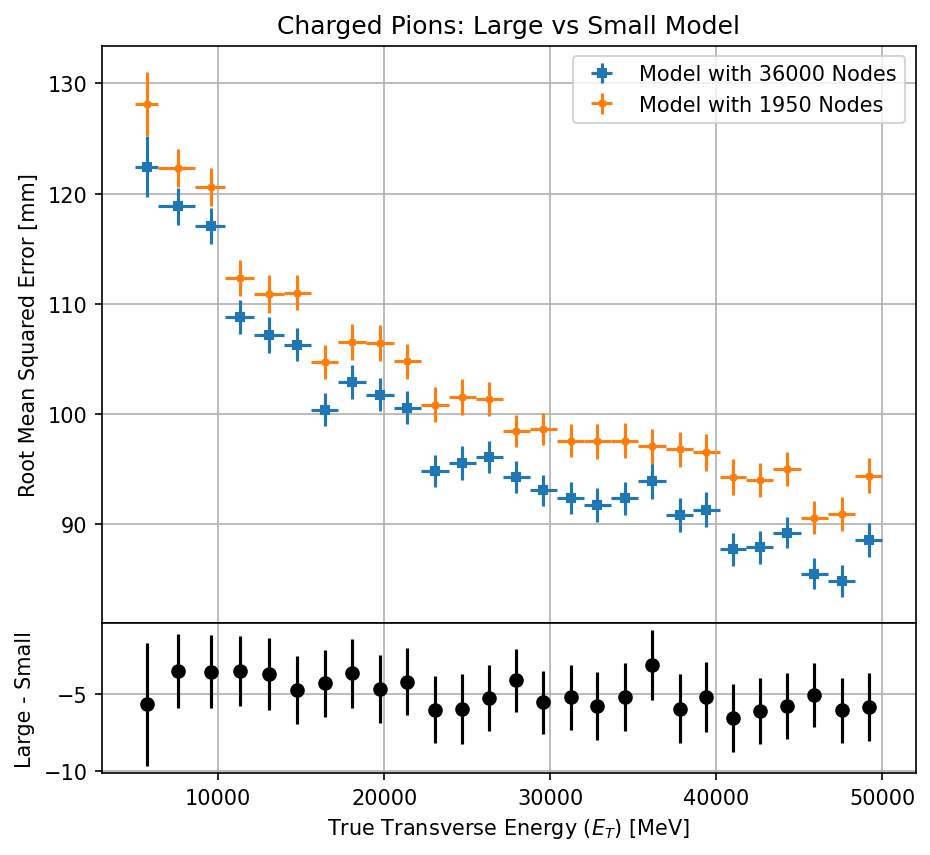

In [43]:
plt.figure(figsize=(7, 5), dpi=150)
plt.errorbar(
    x_pi_char1,
    y_pi_char1,
    xerr=x_u_pi_char1,
    yerr=u_pi_char1,
    fmt="s",
    markersize=4,
    label="Model with 36000 Nodes",
)
plt.errorbar(
    x_pi_char,
    y_pi_char,
    xerr=x_u_pi_char,
    yerr=u_pi_char,
    fmt=".",
    label="Model with 1950 Nodes",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Charged Pions: Large vs Small Model")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_pi_char1) - np.array(y_pi_char)

# Plot the differences
plt.errorbar(
    x_pi_char,
    differences,
    yerr=np.sqrt(u_pi_char**2 + u_pi_char1**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Large - Small")

plt.grid()
plt.show()

In [44]:
u_pi_char

array([2.91715877, 1.71657565, 1.70406222, 1.65497114, 1.69049523,
       1.59896829, 1.54848053, 1.62398953, 1.61719886, 1.58223912,
       1.59259569, 1.64101825, 1.55503447, 1.4659141 , 1.4588261 ,
       1.50900857, 1.57807181, 1.59377329, 1.59934959, 1.61613349,
       1.6687316 , 1.63603681, 1.54887619, 1.56705796, 1.50054559,
       1.53172036, 1.60273212])

In [45]:
utils.save_table_df(
    experiment_hyperparams1.sort_values(by="MSE"), filename="10.0-downsizing_1.csv"
)

In [46]:
utils.save_table_df(
    experiment_hyperparams2.sort_values(by="MSE"), filename="10.0-downsizing_2.csv"
)

In [47]:
utils.save_table_df(
    experiment_hyperparams3.sort_values(by="MSE"), filename="10.0-downsizing_3.csv"
)

In [48]:
utils.save_table_df(
    experiment_hyperparams4.sort_values(by="MSE"), filename="10.0-downsizing_4.csv"
)

In [49]:
utils.save_table_df(
    experiment_hyperparams5.sort_values(by="MSE"), filename="10.0-downsizing_5.csv"
)